In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
import tensorflow as tf

try:
    import keras.backend as K
    if len(K.tensorflow_backend._get_available_gpus()) > 0:
        from keras.layers import CuDNNLSTM as LSTM
        from keras.layers import CuDNNGRU as GRU
except:
    pass

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    print(physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
MAX_SEQUENCE_LENTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 500
LATENT_DIM = 25

In [4]:
input_texts = []
target_texts = []
with open(os.path.join('data', 'robert_frost.txt'), encoding='utf-8') as f :
    for line in f :
        line = line.strip()
        if line :
            input_line = '<sos> ' + line
            target_line = line + ' <eos>'
            
            input_texts.append(input_line)
            target_texts.append(target_line)
            
all_lines = input_texts + target_texts

In [5]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='', oov_token='<oov>')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [6]:
del all_lines

In [7]:
max_sequence_lenth_from_data = max(len(s) for s in input_sequences)
print(f'Max sequence lenth : {max_sequence_lenth_from_data}')

Max sequence lenth : 12


In [8]:
word2idx = tokenizer.word_index
print(f'Found {len(word2idx)} tokens')
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3057 tokens


In [9]:
#padding sequences
max_sequence_lenth = min(max_sequence_lenth_from_data, MAX_SEQUENCE_LENTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_lenth, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_lenth, padding='post')
print(f'Shape of data tensor : {input_sequences.shape}')

Shape of data tensor : (1436, 12)


In [10]:
word2vec = {}
with open(os.path.join('glove', 'glove.6B', 'glove.6B.50d.txt'), encoding="utf-8") as f :
    for line in f :
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype=np.float32)
        word2vec[word] = vec
print(f'Found {len(word2vec)} word vectors.')

Found 400000 word vectors.


In [11]:
#preparing embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1) 
#keras word indexes start from 1, therefore last index will be 20000 instead of 19999
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items() :
    if i < MAX_VOCAB_SIZE :
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None :
            #words not found will be all zeros
            embedding_matrix[i] = embedding_vector

In [12]:
one_hot_targets = np.zeros((len(input_sequences), max_sequence_lenth, num_words))
for i, target_sequence in enumerate(target_sequences) :
    for t, word in enumerate(target_sequence) :
        if word > 0 :
            one_hot_targets[i, t, word] = 1

In [13]:
embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    # trainable=False
)

In [14]:
input_ = Input(shape=(max_sequence_lenth,))
initial_h = Input(shape=[LATENT_DIM,])
initial_c = Input(shape=[LATENT_DIM,])
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c])
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 12, 50)       150000      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                              

In [15]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

In [16]:
input_sequences.shape

(1436, 12)

In [17]:
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
    [input_sequences, z, z],
    one_hot_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    workers=8,
    verbose=0
)

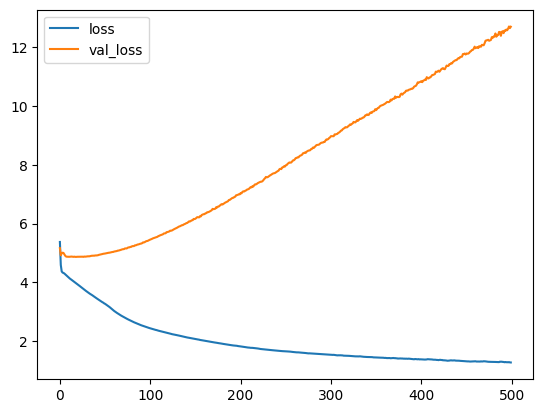

In [18]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

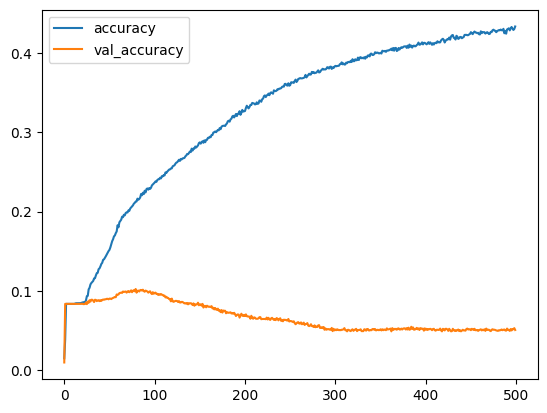

In [19]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [22]:
#sampling model
input2 = Input(shape=(1,))
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c])
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])
sampling_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          multiple             150000      ['input_5[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                            

In [23]:
idx2word = tokenizer.index_word

In [28]:
def sample_line() :
    np_input = np.array([[word2idx['<sos>']]])
    h = np.zeros((1, LATENT_DIM)) #1 sample and sequence of lenth 1
    c = np.zeros((1, LATENT_DIM))
    
    eos = word2idx['<eos>']
    
    output_sentence = []
    
    for _ in range(max_sequence_lenth) :
        o, h, c = sampling_model.predict([np_input, h, c], verbose=0) #o is a list of prob for next word
        #h and c are next hidden states and cell states
        
        # print(f'o shape : {o.shape}')
        # print(f'h shape : {h.shape}')
        # print(f'c shape : {c.shape}')
        
        #sometimes prob give very high prob to 0 i.e no word
        probs = o[0, 0]
        if np.argmax(probs) == 0 :
            print('<PROB ERR>')
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(probs), p = probs)
        if idx == eos :
            break
            
        output_sentence.append(idx2word.get(idx, ''))
        
        #make the output as the next input for the model
        np_input[0, 0] = idx
        
    return ' '.join(output_sentence)
        

In [30]:
while True :
    for _ in range(4) :
        print(sample_line())
        
    ans = input('======= GENERATE ANOTHER? [Y/n] =======')
    if ans and ans[0].lower().startswith('n'):
        break

at least they were. i stay it,
a rock-strewn town in spring
two roads diverged in a wood, and lift ice
at having eased her heart of love,


======= GENERATE ANOTHER? [Y/n] ======= n
